# SNPE with summary stats

In [9]:
import numpy as np
from scipy.integrate import odeint

def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1,k2,k3,a1,a2,a3=params
    #for now we are setting a, g, n, b dm, dp to be constant
    g1 = g2 = g3 = 0.024884149937163258
    n1 = n2 = n3 = 5.
    b1 = b2 = b3 = 33.82307682700831
    dm1 = dm2 = dm3 =1.143402097500176
    dp1 = dp2 = dp3 = 0.7833664565550977
    dm1dt = -dm1*m1 + (a1 / (1 + ((1/k1) * p2)**n1)) + g1
    dp1dt = (b1*m1) - (dp1*p1)
    dm2dt = -dm2*m2 + (a2 / (1 + ((1/k2) * p3)**n2)) + g2
    dp2dt = (b2*m2) - (dp2*p2)
    dm3dt = -dm3*m3 + (a3 / (1 + ((1/k3) * p1)**n3)) + g3
    dp3dt = (b3*m3)-(dp3*p3)
    return np.array([dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt])

def solve_ode(params):
    initial_conditions = np.array([0, 2, 0, 1, 0, 3])
    solution = odeint(model, initial_conditions, t=np.linspace(0,100,100), args=(params,)) # The initial value point should be the first element of this sequence
    return solution

timepoints = int(100)
third = int(timepoints / 3)
#truncated_traj = true_data[third:timepoints,:]

from scipy.signal import find_peaks

def summarise(solution):
    """Calculate summary statistics
        requires solution to be the result of calling solve_ode[parameters]
        e.g. true_data
        Returns
        -------
        a 1D array of summary statistics containing the mean of solution, the log variance of solution, the autocorrelation at lag 10, cross correlation of mRNA and protein species separately, number of peaks
        """
    mean=np.mean(solution, axis=0)
    var=np.var(solution, axis=0)
    #The autocorrelation coefficient of each time series at lag 10 and lag 5
    #can be altered
    auto_cor=np.corrcoef(solution[10:,:], solution[:-10,:], rowvar=False)[6:,:]
    auto_cor_coef=np.diag(auto_cor)
    cor=np.corrcoef(solution, solution, rowvar=False)[:6,2:8]
    cor_coef=np.diag(cor)
    #returning cross correlation coefficients of mRNA to mRNA species, protein to protein species
    truncated_trajectory=solution[third:timepoints,:]
    peaks,_=zip(*(find_peaks(truncated_trajectory[:,i], height=0) for i in range(6)))
    peak_count=np.array([len(p) for p in peaks])
    return(np.concatenate([mean, var, auto_cor_coef, cor_coef, peak_count.flatten()]))


In [10]:
def find_mean_std(num_samples):
    """a function that returns the mean and standard deviation of the summary statistics of the simulated data, for the number of samples specified"""
#generate an empty np array to store simulated data
    simulated_arr=np.zeros((num_samples, 30))
    for i in range(num_samples):
        params_val=np.concatenate((np.random.default_rng().uniform(0.01,250,3),np.random.default_rng().uniform(20.,40.,3))).flatten()
        simulated_data=solve_ode(params_val)
        simulated_arr[i,:]=summarise(simulated_data)
    s_std=np.std(simulated_arr, axis=0)
    s_mean=np.mean(simulated_arr, axis=0)
    return(s_mean, s_std)

m1,s1=find_mean_std(10000)

def normalise(sum_stats, mean, std):
    """takes in sum stats of 1 by 30 array, mean and std are both 1 by 30 arrays, normalise data by the empirically calculated mean and std"""
    normalised=(sum_stats-mean)/std
    return(normalised)

In [24]:
import torch
import sbi
import numpy as np
from scipy.integrate import odeint
from sbi.inference import SNRE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import random
import time

num_timesteps = 1000
num_rounds = 2       # how many rounds of SNRE (5-10 is good)
t = np.linspace(0, 100, num_timesteps)

def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1,k2,k3,a1,a2,a3=params
    #for now we are setting a, g, n, b dm, dp to be constant
    g1 = g2 = g3 = 0.024884149937163258
    n1 = n2 = n3 = 5.
    b1 = b2 = b3 = 33.82307682700831
    dm1 = dm2 = dm3 =1.143402097500176
    dp1 = dp2 = dp3 = 0.7833664565550977
    dm1dt = -dm1*m1 + (a1 / (1 + ((1/k1) * p2)**n1)) + g1
    dp1dt = (b1*m1) - (dp1*p1)
    dm2dt = -dm2*m2 + (a2 / (1 + ((1/k2) * p3)**n2)) + g2
    dp2dt = (b2*m2) - (dp2*p2)
    dm3dt = -dm3*m3 + (a3 / (1 + ((1/k3) * p1)**n3)) + g3
    dp3dt = (b3*m3)-(dp3*p3)
    return np.array([dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt])

true_params=[200.,200.,200.,24.78485282457379,24.78485282457379,24.78485282457379]

def my_simulator(theta):
    initial_conditions = np.array([0, 2, 0, 1, 0, 3], dtype=np.float32)
    solution = odeint(model, initial_conditions, t, args=(theta,))
    summarised_data = summarise(solution)
    normalised_ss=normalise(summarised_data, m1, s1)
    return torch.tensor(normalised_ss, dtype=torch.float32) 

x_o = my_simulator(true_params) # Generate observations,with data from 100 timepoints for each of 6 variables
prior = utils.BoxUniform(
    low=torch.tensor([10**-2,10**-2,10**-2,20.,20.,20.]),
    high=torch.tensor([250.,250.,250.,40.,40.,40.])
)
simulator, prior = prepare_for_sbi(my_simulator, prior)  

In [ ]:
#New integration method

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import numpy as np

def euler_method(func, y0, t, params):
    num_eqns = len(y0)
    y = np.zeros((len(t), num_eqns))
    y[0] = y0
    dt = t[1] - t[0]
    for i in range(1, len(t)):
        y[i] = y[i - 1] + dt * func(t[i - 1], y[i - 1], params)
    return y

# Example function representing a system of ODEs with parameters
def system_of_odes(t, y, params):
    dydt = np.zeros_like(y)

    m1, p1, m2, p2, m3, p3 = y
    k1, k2, k3 = params #only 3 ks are parameters to infer
    a1 = a2 = a3 = 24.78485282457379
    g1 = g2 = g3 = 0.024884149937163258
    n1 = n2 = n3 = 5
    b1 = b2 = b3 = 33.82307682700831
    dm1 = dm2 = dm3 = 1.143402097500176
    dp1 = dp2 = dp3 = 0.7833664565550977

    dydt[0] = -dm1 * m1 + (a1 / (1 + ((1/k1) * p2) ** n1)) + g1
    dydt[1] = (b1 * m1) - (dp1 * p1)
    dydt[2] = -dm2 * m2 + (a2 / (1 + ((1/k2) * p3) ** n2)) + g2
    dydt[3] = (b2 * m2) - (dp2 * p2)
    dydt[4] = -dm3 * m3 + (a3 / (1 + ((1/k3) * p1) ** n3)) + g3
    dydt[5] = (b3 * m3)-(dp3 * p3)
    
    return dydt

# Initial conditions
true_params = torch.tensor([
    206.96291990024542, 246.96291990024542, 246.96291990024542]).unsqueeze(0)
num_timesteps = 1000
num_trajectories = 6
y0 = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

def simulator(parameter_set):
    full_tensor = torch.zeros((num_trajectories * num_timesteps)).unsqueeze(0)
    if len(parameter_set) == 1:
        for params in parameter_set:
            y = euler_method(system_of_odes, y0, t, params)
            y_transposed = y.T
            concatenated_trajectories = y_transposed.flatten()
            yt = torch.tensor(concatenated_trajectories)
            final_tensor = yt.unsqueeze(0).unsqueeze(-1)
            return final_tensor
    else:
        for params in parameter_set:
            y = euler_method(system_of_odes, y0, t, params)
            y_transposed = y.T
            concatenated_trajectories = y_transposed.flatten()
            yt = torch.tensor(concatenated_trajectories)
            true_tensor = yt.unsqueeze(0)
            full_tensor = torch.cat((full_tensor, true_tensor), dim=0)
        n_sims = full_tensor.size(0)
        output_tensor = full_tensor[1:n_sims]
        out = output_tensor.unsqueeze(-1)
        return out
    
num_dim = 3
prior = utils.BoxUniform(low=10**-2 * torch.ones(num_dim), high=250 * torch.ones(num_dim))
   

In [26]:
#Parallelise it
# PART 1: Edited code from original sbi repos. Functions edited: simulate_for_sbi, and all the functions it contains.
#Main changes: defined simulator_seeded globally rather than within simulate_in_batches function, and re-imported torch within simulator_seeded 
#NO changes need to be made in this file

# PART 2: Essentially the unparallelised code with 2 extra arguments in the simulate_for_sbi line

##################################### PART 1 #########################################
import joblib
import contextlib
import random
import torch
import numpy as np

from torch import Tensor, split, randint, cat
from typing import Any, Callable, Optional, Tuple, Union
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm.auto import tqdm

import sbi
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os

from sbi.inference import SNLE, prepare_for_sbi
# No longer importing simulate_for_sbi from the package, we use the one defined above
from sbi import utils as utils
from sbi import analysis as analysis

def seed_all_backends(seed: Optional[Union[int, Tensor]] = None) -> None:
    if seed is None:
        seed = int(torch.randint(1_000_000, size=(1,)))
    else:
        # Cast Tensor to int (required by math.random since Python 3.11)
        seed = int(seed)

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # type: ignore
    torch.backends.cudnn.benchmark = False # type: ignore

def simulator_seeded(simulator: Callable, theta: Tensor, seed: int) -> Tensor:
    import torch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    with torch.random.fork_rng(devices=[]):
        torch.manual_seed(seed)
        return simulator(theta)

def simulate_in_batches(simulator: Callable, theta: Tensor, sim_batch_size: int = 1, num_workers: int = 1,
                        seed: Optional[int] = None, show_progress_bars: bool = True, ) -> Tensor:

    num_sims, *_ = theta.shape
    seed_all_backends(seed)

    if num_sims == 0:
        x = torch.tensor([])
    elif sim_batch_size is not None and sim_batch_size < num_sims:
        batches = split(theta, sim_batch_size, dim=0)

        if num_workers != 1:
            batch_seeds = randint(high=1_000_000, size=(len(batches),))

            with tqdm_joblib(
                tqdm(batches, disable=not show_progress_bars,
                     desc=f"Running {num_sims} simulations in {len(batches)} batches.", total=len(batches),)) as _:
                simulation_outputs = Parallel(n_jobs=num_workers)(delayed(simulator_seeded)(simulator, batch, batch_seed)
                    for batch, batch_seed in zip(batches, batch_seeds))
        else:
            pbar = tqdm(total=num_sims, disable=not show_progress_bars, desc=f"Running {num_sims} simulations.", )

            with pbar:
                simulation_outputs = []
                for batch in batches:
                    simulation_outputs.append(simulator_seeded(simulator, batch, seed))
                    pbar.update(sim_batch_size)

        x = cat(simulation_outputs, dim=0)
    else:
        x = simulator(theta)

    return x


@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    def tqdm_print_progress(self):
        if self.n_completed_tasks > tqdm_object.n:
            n_completed = self.n_completed_tasks - tqdm_object.n
            tqdm_object.update(n=n_completed)

    original_print_progress = joblib.parallel.Parallel.print_progress
    joblib.parallel.Parallel.print_progress = tqdm_print_progress

    try:
        yield tqdm_object
    finally:
        joblib.parallel.Parallel.print_progress = original_print_progress
        tqdm_object.close()

def simulate_for_sbi(simulator: Callable, proposal: Any, num_simulations: int, num_workers: int = 1,
                     simulation_batch_size: int = 1, seed: Optional[int] = None,
                     show_progress_bar: bool = True, ) -> Tuple[Tensor, Tensor]:

    theta = proposal.sample((num_simulations,))

    x = simulate_in_batches(simulator=simulator, theta=theta, sim_batch_size=simulation_batch_size,
                            num_workers=num_workers, seed=seed, show_progress_bars=show_progress_bar,)

    return theta, x

######################################################################################################

simulation_batch_size = 200
num_simulations = 1200

# To parallelise, set number of CPUs to be used. Note: parallelise anything that has num_rounds>2 and/or num_simulations>50
# to see total available CPUs: print(os.cpu_count())

CPUs_to_use = 8

total_CPUs = os.cpu_count()
num_workers = CPUs_to_use - total_CPUs -1
# num_workers = -1 uses all cpus
# num_workers = -2 uses all cpus but one etc https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html
if CPUs_to_use > total_CPUs:
    raise ValueError(f"Cannot use more CPUs than are available. Available CPUs: {total_CPUs}")

#### Important to parallelisation code to be right before the SNPE code...

In [27]:
# The specific observation we want to focus the inference on.
posteriors = []
proposal = prior
inference = SNPE(prior=prior)
for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=num_simulations, simulation_batch_size=simulation_batch_size, num_workers=num_workers)
    # In `SNLE` and `SNRE`, you should not pass the `proposal` to `.append_simulations()`
    density_estimator = inference.append_simulations(
        theta, x, proposal = proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o) 

Running 1200 simulations in 6 batches.:   0%|          | 0/6 [00:00<?, ?it/s]

 Neural network successfully converged after 140 epochs.

Drawing 1200 posterior samples:   0%|          | 0/1200 [00:00<?, ?it/s]

Running 1200 simulations in 6 batches.:   0%|          | 0/6 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 50 epochs.

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

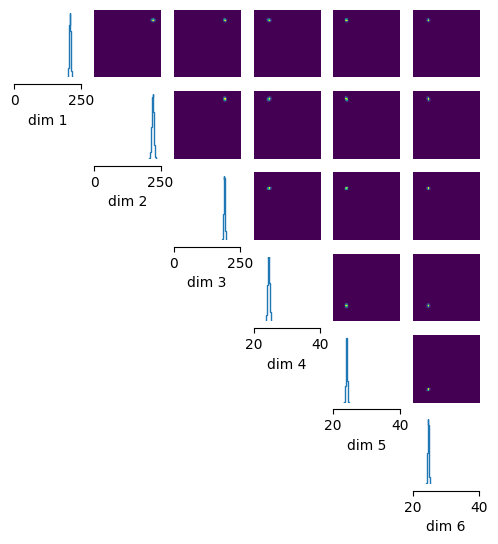

In [30]:
# Then sample the posterior and plot
posterior_samples = posterior.sample((50000,), x=x_o)
_ = analysis.pairplot(
    posterior_samples, limits=[[0, 250], [0,250], [0,250],[20,40],[20,40],[20,40]], figsize=(6, 6) #It should be close to 247, but since this is a toy example we are not expecting it to work (just checking it runs).
)

In [31]:
posterior

DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>

In [34]:
true_ms = my_simulator(true_params)
true_ms.shape

torch.Size([30])

In [37]:
true_s = simulator(torch.tensor(true_params).unsqueeze(0))

In [39]:
true_s.shape

torch.Size([1, 30])

In [40]:
batch_size = 3
fourdim = simulator(prior.sample((batch_size,)))
fourdim.shape

torch.Size([3, 30])